In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt 
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data=np.load(r'C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_11_18_sample_100x100x5mm_no_defect_isotropic_gaussian_heat_no_conv_cond_5.npz',allow_pickle=True)

In [4]:
data['meta']

array([['time', '18/11/2025 21:36:12'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '30'],
       ['T2_units', 'frames'],
       ['T3', '300'],
       ['T3_units', 'frames'],
       ['fps', '30.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '334'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '5.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J/(kg

In [5]:
# Normalize temperature data with the envireoment
temp=data['data']
temp=(temp-temp.min())/(temp.max()-temp.min())
print(f"Temp min: {temp.min()} | Temp max: {temp.max()}")

Temp min: 0.0 | Temp max: 1.0


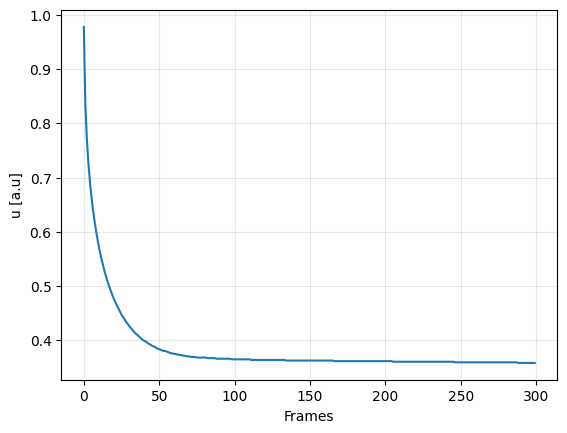

In [6]:
T,Y,X=temp.shape
y_center=Y//2
x_center=X//2
u_np=temp[34:,y_center,x_center]
plt.plot(u_np)
plt.xlabel('Frames')
plt.ylabel('u [a.u]')
plt.grid(alpha=0.3)

In [7]:
print(f"Temp min: {u_np.min()} | Temp max: {u_np.max()}")

Temp min: 0.35792951541850226 | Temp max: 0.9779735682819384


In [8]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS,a_phys=1e-6):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

        self.a = nn.Parameter(torch.log(torch.tensor([a_phys], dtype=torch.float32)))

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [9]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(2,1,32,4).to(device)

# Measured data
u=torch.from_numpy(u_np).to(torch.float32).view(-1,1)

In [10]:
t=torch.linspace(0,10,300).view(-1,1)
x_boundary=torch.zeros_like(u)

x_data=torch.hstack([t,x_boundary])
x_boundary_back=torch.tensor([0.0,0.1,10.0,0.1]).view(-1,2)
X=torch.concatenate([x_data,x_boundary_back],dim=0)

In [11]:
u_back=torch.tensor([0.0,u[-1]]).view(-1,1)
u_back
Y=torch.vstack([u,u_back])

In [12]:
# Collocation points
res=100 # Resolution parameter to our solution
time_res=300
z_coll=torch.linspace(0,0.005,res)
t_coll=torch.linspace(0,10,time_res)

# Torch meshgrid only accept 1d tensors as input
T_mesh, X_mesh = torch.meshgrid(t_coll, z_coll, indexing='ij')
X_coll = torch.stack([T_mesh.reshape(-1), X_mesh.reshape(-1)], dim=1)

In [13]:
X=X.requires_grad_(True).to(device)
Y=Y.requires_grad_(True).to(device)
X_coll=X_coll.requires_grad_(True).to(device)
flux_at_boundary=torch.zeros_like(Y).requires_grad_(True).to(device)

In [14]:
n_epoch=30001

log_losses=[]
log_data_losses=[]
log_bnd_losses=[]
log_pde_losses=[]
log_a=[]


optimiser=optim.Adam(pinn.parameters(),lr=1e-4)
for i in tqdm(range(n_epoch)):
  optimiser.zero_grad()
    
  # compute each term of the PINN loss function above
  # using the following hyperparameters
  lambda1, lambda2, lambda3 = 1, 1e-1, 1.0

  # Calculate boundary loss data
  u_p=pinn(X)
  loss1=torch.mean((u_p-Y)**2)

  # Calculate Neuman boundary loss
  u_tx=torch.autograd.grad(u_p,X,torch.ones_like(u_p),create_graph=True)[0]
  u_t=u_tx[:,0].view(-1,1) # Time gradient
  u_x=u_tx[:,1].view(-1,1) # Space gradient
  loss2=torch.mean((u_x-flux_at_boundary)**2)

  # Calculate PDE loss
  u_coll=pinn(X_coll)
  u_coll_tx=torch.autograd.grad(u_coll,X_coll,torch.ones_like(u_coll),create_graph=True)[0]
  u_coll_t=u_coll_tx[:,0].view(-1,1) # Gradient in time
  u_coll_x=u_coll_tx[:,1].view(-1,1) # Gradient in space

  u_coll_xx=torch.autograd.grad(u_coll_x,X_coll,torch.ones_like(u_coll_x),create_graph=True)[0][:,1].view(-1,1)
    
  a_actual=torch.exp(pinn.a)
  f=u_coll_t-a_actual*u_coll_xx
  loss3=torch.mean(f**2)

  losses=lambda1*loss1+lambda2*loss2+lambda3*loss3    

  losses.backward()
  optimiser.step()

  log_losses.append(losses.item())
  log_data_losses.append(loss1.item())
  log_bnd_losses.append(loss2.item())
  log_pde_losses.append(loss3.item())
  log_a.append(a_actual.item())

  if i % 500 == 0:
    print(f"[{i}] "
          f"Total: {losses.item():.4e} | "
          f"Data: {loss1.item():.4e} | "
          f"Boundary: {loss2.item():.4e} | "
          f"PDE: {loss3.item():.4e}"
          f" | a: {a_actual.item():.4e}"
          )




  0%|          | 0/30001 [00:00<?, ?it/s]c:\Users\stone\Anisotropic_diffusivity_2\venv\Lib\site-packages\torch\autograd\graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 14/30001 [00:00<10:36, 47.12it/s] 

[0] Total: 3.5220e-01 | Data: 3.5193e-01 | Boundary: 1.5352e-03 | PDE: 1.1623e-04 | a: 1.0000e-06


  2%|▏         | 521/30001 [00:04<03:50, 127.71it/s]

[500] Total: 5.7959e-03 | Data: 5.2574e-03 | Boundary: 1.5969e-04 | PDE: 5.2248e-04 | a: 9.9431e-07


  3%|▎         | 1015/30001 [00:08<03:47, 127.29it/s]

[1000] Total: 3.7166e-03 | Data: 3.2258e-03 | Boundary: 9.5135e-06 | PDE: 4.8980e-04 | a: 9.9542e-07


  5%|▌         | 1522/30001 [00:12<03:46, 125.99it/s]

[1500] Total: 3.6160e-03 | Data: 3.0225e-03 | Boundary: 2.4463e-05 | PDE: 5.9112e-04 | a: 9.9941e-07


  7%|▋         | 2016/30001 [00:16<03:38, 128.23it/s]

[2000] Total: 3.5961e-03 | Data: 2.9853e-03 | Boundary: 2.8969e-05 | PDE: 6.0789e-04 | a: 1.0041e-06


  8%|▊         | 2525/30001 [00:20<03:36, 126.98it/s]

[2500] Total: 3.5926e-03 | Data: 2.9730e-03 | Boundary: 3.5916e-05 | PDE: 6.1604e-04 | a: 1.0089e-06


 10%|█         | 3022/30001 [00:23<03:27, 130.06it/s]

[3000] Total: 3.5914e-03 | Data: 2.9680e-03 | Boundary: 4.0574e-05 | PDE: 6.1935e-04 | a: 1.0137e-06


 12%|█▏        | 3518/30001 [00:27<03:28, 126.77it/s]

[3500] Total: 3.5904e-03 | Data: 2.9649e-03 | Boundary: 4.2434e-05 | PDE: 6.2133e-04 | a: 1.0185e-06


 13%|█▎        | 4014/30001 [00:31<03:21, 129.12it/s]

[4000] Total: 3.5894e-03 | Data: 2.9620e-03 | Boundary: 4.3760e-05 | PDE: 6.2302e-04 | a: 1.0235e-06


 15%|█▌        | 4522/30001 [00:35<03:18, 128.04it/s]

[4500] Total: 3.5882e-03 | Data: 2.9591e-03 | Boundary: 4.5831e-05 | PDE: 6.2454e-04 | a: 1.0288e-06


 17%|█▋        | 5018/30001 [00:39<03:15, 128.09it/s]

[5000] Total: 3.5870e-03 | Data: 2.9561e-03 | Boundary: 4.9345e-05 | PDE: 6.2592e-04 | a: 1.0343e-06


 18%|█▊        | 5514/30001 [00:43<03:13, 126.49it/s]

[5500] Total: 3.5857e-03 | Data: 2.9530e-03 | Boundary: 5.4846e-05 | PDE: 6.2721e-04 | a: 1.0401e-06


 20%|██        | 6025/30001 [00:47<03:05, 129.07it/s]

[6000] Total: 3.5844e-03 | Data: 2.9497e-03 | Boundary: 6.2606e-05 | PDE: 6.2845e-04 | a: 1.0463e-06


 22%|██▏       | 6517/30001 [00:51<03:02, 128.73it/s]

[6500] Total: 3.5831e-03 | Data: 2.9462e-03 | Boundary: 7.2394e-05 | PDE: 6.2960e-04 | a: 1.0531e-06


 23%|██▎       | 7012/30001 [00:55<02:59, 128.05it/s]

[7000] Total: 3.5817e-03 | Data: 2.9428e-03 | Boundary: 8.3392e-05 | PDE: 6.3061e-04 | a: 1.0606e-06


 25%|██▌       | 7520/30001 [00:59<02:58, 126.29it/s]

[7500] Total: 3.5804e-03 | Data: 2.9395e-03 | Boundary: 9.4484e-05 | PDE: 6.3144e-04 | a: 1.0690e-06


 27%|██▋       | 8016/30001 [01:03<02:52, 127.48it/s]

[8000] Total: 3.5788e-03 | Data: 2.9362e-03 | Boundary: 1.0506e-04 | PDE: 6.3214e-04 | a: 1.0785e-06


 28%|██▊       | 8523/30001 [01:07<02:50, 125.81it/s]

[8500] Total: 3.5771e-03 | Data: 2.9327e-03 | Boundary: 1.1577e-04 | PDE: 6.3280e-04 | a: 1.0893e-06


 30%|███       | 9018/30001 [01:10<02:44, 127.86it/s]

[9000] Total: 3.5752e-03 | Data: 2.9288e-03 | Boundary: 1.2845e-04 | PDE: 6.3348e-04 | a: 1.1016e-06


 32%|███▏      | 9515/30001 [01:14<02:39, 128.70it/s]

[9500] Total: 3.5731e-03 | Data: 2.9243e-03 | Boundary: 1.4539e-04 | PDE: 6.3419e-04 | a: 1.1155e-06


 33%|███▎      | 10024/30001 [01:18<02:37, 126.83it/s]

[10000] Total: 3.5711e-03 | Data: 2.9198e-03 | Boundary: 1.6715e-04 | PDE: 6.3459e-04 | a: 1.1315e-06


 35%|███▌      | 10522/30001 [01:22<02:31, 128.20it/s]

[10500] Total: 3.5693e-03 | Data: 2.9153e-03 | Boundary: 1.9130e-04 | PDE: 6.3485e-04 | a: 1.1495e-06


 37%|███▋      | 11021/30001 [01:26<02:28, 127.70it/s]

[11000] Total: 3.5681e-03 | Data: 2.9112e-03 | Boundary: 2.1407e-04 | PDE: 6.3543e-04 | a: 1.1694e-06


 38%|███▊      | 11520/30001 [01:30<02:24, 127.66it/s]

[11500] Total: 3.5673e-03 | Data: 2.9091e-03 | Boundary: 2.3187e-04 | PDE: 6.3497e-04 | a: 1.1909e-06


 40%|████      | 12016/30001 [01:34<02:19, 128.94it/s]

[12000] Total: 3.5669e-03 | Data: 2.9075e-03 | Boundary: 2.4280e-04 | PDE: 6.3512e-04 | a: 1.2135e-06


 42%|████▏     | 12519/30001 [01:38<02:15, 129.07it/s]

[12500] Total: 3.5667e-03 | Data: 2.9067e-03 | Boundary: 2.4862e-04 | PDE: 6.3516e-04 | a: 1.2374e-06


 43%|████▎     | 13024/30001 [01:42<02:11, 128.92it/s]

[13000] Total: 3.5665e-03 | Data: 2.9061e-03 | Boundary: 2.5188e-04 | PDE: 6.3527e-04 | a: 1.2627e-06


 45%|████▌     | 13521/30001 [01:45<02:08, 128.31it/s]

[13500] Total: 3.5663e-03 | Data: 2.9053e-03 | Boundary: 2.5437e-04 | PDE: 6.3559e-04 | a: 1.2897e-06


 47%|████▋     | 14017/30001 [01:49<02:05, 127.41it/s]

[14000] Total: 3.5661e-03 | Data: 2.9050e-03 | Boundary: 2.5764e-04 | PDE: 6.3531e-04 | a: 1.3189e-06


 48%|████▊     | 14513/30001 [01:53<02:02, 126.65it/s]

[14500] Total: 3.5658e-03 | Data: 2.9043e-03 | Boundary: 2.6219e-04 | PDE: 6.3528e-04 | a: 1.3509e-06


 50%|█████     | 15010/30001 [01:57<01:57, 127.58it/s]

[15000] Total: 3.5652e-03 | Data: 2.9035e-03 | Boundary: 2.6957e-04 | PDE: 6.3483e-04 | a: 1.3863e-06


 52%|█████▏    | 15520/30001 [02:01<01:54, 126.96it/s]

[15500] Total: 3.5641e-03 | Data: 2.9026e-03 | Boundary: 2.8300e-04 | PDE: 6.3321e-04 | a: 1.4272e-06


 53%|█████▎    | 16014/30001 [02:05<01:51, 125.90it/s]

[16000] Total: 3.5604e-03 | Data: 2.8954e-03 | Boundary: 3.0649e-04 | PDE: 6.3431e-04 | a: 1.4785e-06


 55%|█████▌    | 16523/30001 [02:09<01:44, 128.75it/s]

[16500] Total: 3.5459e-03 | Data: 2.8759e-03 | Boundary: 3.5508e-04 | PDE: 6.3441e-04 | a: 1.5519e-06


 57%|█████▋    | 17018/30001 [02:13<01:40, 129.15it/s]

[17000] Total: 3.4836e-03 | Data: 2.7985e-03 | Boundary: 4.4235e-04 | PDE: 6.4091e-04 | a: 1.6707e-06


 58%|█████▊    | 17518/30001 [02:17<01:35, 130.10it/s]

[17500] Total: 3.1759e-03 | Data: 2.4700e-03 | Boundary: 4.5241e-04 | PDE: 6.6071e-04 | a: 1.8696e-06


 60%|██████    | 18019/30001 [02:21<01:32, 128.97it/s]

[18000] Total: 2.7710e-03 | Data: 1.9831e-03 | Boundary: 2.3798e-04 | PDE: 7.6408e-04 | a: 2.1084e-06


 62%|██████▏   | 18514/30001 [02:25<01:29, 127.76it/s]

[18500] Total: 2.7333e-03 | Data: 1.9356e-03 | Boundary: 1.0772e-04 | PDE: 7.8690e-04 | a: 2.3006e-06


 63%|██████▎   | 19023/30001 [02:29<01:25, 128.40it/s]

[19000] Total: 2.7261e-03 | Data: 1.9303e-03 | Boundary: 5.3122e-05 | PDE: 7.9047e-04 | a: 2.4621e-06


 65%|██████▌   | 19519/30001 [02:32<01:21, 128.72it/s]

[19500] Total: 2.7229e-03 | Data: 1.9306e-03 | Boundary: 3.2723e-05 | PDE: 7.8907e-04 | a: 2.6166e-06


 67%|██████▋   | 20020/30001 [02:36<01:18, 126.35it/s]

[20000] Total: 2.7212e-03 | Data: 1.9296e-03 | Boundary: 2.3879e-05 | PDE: 7.8919e-04 | a: 2.7733e-06


 68%|██████▊   | 20519/30001 [02:40<01:13, 129.86it/s]

[20500] Total: 2.7201e-03 | Data: 1.9284e-03 | Boundary: 1.9113e-05 | PDE: 7.8985e-04 | a: 2.9360e-06


 70%|███████   | 21020/30001 [02:45<01:11, 126.40it/s]

[21000] Total: 2.7193e-03 | Data: 1.9283e-03 | Boundary: 1.6035e-05 | PDE: 7.8939e-04 | a: 3.1074e-06


 72%|███████▏  | 21515/30001 [02:48<01:06, 127.42it/s]

[21500] Total: 2.7186e-03 | Data: 1.9280e-03 | Boundary: 1.3669e-05 | PDE: 7.8923e-04 | a: 3.2888e-06


 73%|███████▎  | 22023/30001 [02:52<01:01, 128.91it/s]

[22000] Total: 2.7180e-03 | Data: 1.9256e-03 | Boundary: 1.1705e-05 | PDE: 7.9124e-04 | a: 3.4809e-06


 75%|███████▌  | 22518/30001 [02:56<00:58, 128.44it/s]

[22500] Total: 2.7174e-03 | Data: 1.9268e-03 | Boundary: 1.0239e-05 | PDE: 7.8960e-04 | a: 3.6841e-06


 77%|███████▋  | 23021/30001 [03:00<00:57, 120.86it/s]

[23000] Total: 2.7169e-03 | Data: 1.9258e-03 | Boundary: 8.9617e-06 | PDE: 7.9017e-04 | a: 3.9001e-06


 78%|███████▊  | 23517/30001 [03:04<00:49, 129.75it/s]

[23500] Total: 2.7167e-03 | Data: 1.9302e-03 | Boundary: 8.1910e-06 | PDE: 7.8562e-04 | a: 4.1298e-06


 80%|████████  | 24025/30001 [03:08<00:46, 127.48it/s]

[24000] Total: 2.7215e-03 | Data: 1.9483e-03 | Boundary: 8.4938e-06 | PDE: 7.7238e-04 | a: 4.3730e-06


 82%|████████▏ | 24517/30001 [03:13<00:47, 114.96it/s]

[24500] Total: 2.7153e-03 | Data: 1.9245e-03 | Boundary: 6.5234e-06 | PDE: 7.9010e-04 | a: 4.6320e-06


 83%|████████▎ | 25012/30001 [03:17<00:38, 129.24it/s]

[25000] Total: 2.7147e-03 | Data: 1.9245e-03 | Boundary: 6.0730e-06 | PDE: 7.8955e-04 | a: 4.9071e-06


 85%|████████▌ | 25510/30001 [03:20<00:35, 127.82it/s]

[25500] Total: 2.7141e-03 | Data: 1.9241e-03 | Boundary: 5.7188e-06 | PDE: 7.8946e-04 | a: 5.1986e-06


 87%|████████▋ | 26012/30001 [03:24<00:30, 130.39it/s]

[26000] Total: 2.7134e-03 | Data: 1.9236e-03 | Boundary: 5.4651e-06 | PDE: 7.8932e-04 | a: 5.5083e-06


 88%|████████▊ | 26518/30001 [03:28<00:26, 130.10it/s]

[26500] Total: 2.7127e-03 | Data: 1.9230e-03 | Boundary: 5.2838e-06 | PDE: 7.8917e-04 | a: 5.8383e-06


 90%|█████████ | 27025/30001 [03:32<00:23, 129.33it/s]

[27000] Total: 2.7120e-03 | Data: 1.9231e-03 | Boundary: 5.2014e-06 | PDE: 7.8840e-04 | a: 6.1880e-06


 92%|█████████▏| 27514/30001 [03:36<00:19, 128.48it/s]

[27500] Total: 2.7111e-03 | Data: 1.9215e-03 | Boundary: 5.1411e-06 | PDE: 7.8909e-04 | a: 6.5587e-06


 93%|█████████▎| 28014/30001 [03:40<00:15, 129.62it/s]

[28000] Total: 2.7102e-03 | Data: 1.9211e-03 | Boundary: 5.0896e-06 | PDE: 7.8863e-04 | a: 6.9539e-06


 95%|█████████▌| 28515/30001 [03:44<00:11, 128.85it/s]

[28500] Total: 2.7092e-03 | Data: 1.9204e-03 | Boundary: 5.1059e-06 | PDE: 7.8831e-04 | a: 7.3740e-06


 97%|█████████▋| 29015/30001 [03:48<00:07, 131.20it/s]

[29000] Total: 2.7081e-03 | Data: 1.9196e-03 | Boundary: 5.1282e-06 | PDE: 7.8801e-04 | a: 7.8194e-06


 98%|█████████▊| 29519/30001 [03:52<00:03, 129.16it/s]

[29500] Total: 2.7069e-03 | Data: 1.9185e-03 | Boundary: 5.1410e-06 | PDE: 7.8785e-04 | a: 8.2938e-06


100%|██████████| 30001/30001 [03:56<00:00, 127.12it/s]

[30000] Total: 2.7055e-03 | Data: 1.9196e-03 | Boundary: 5.2342e-06 | PDE: 7.8540e-04 | a: 8.7989e-06


In [15]:
torch.exp(pinn.a)

tensor([8.8000e-06], device='cuda:0', grad_fn=<ExpBackward0>)

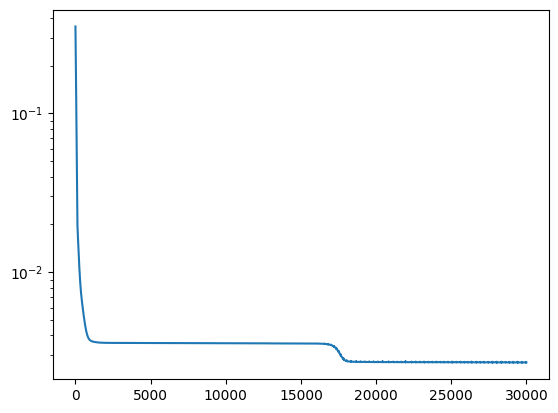

In [16]:
plt.semilogy(log_losses, label='Total Loss')

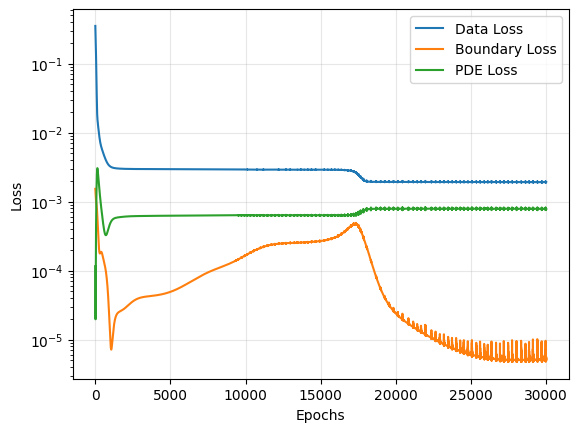

In [17]:
plt.semilogy(log_data_losses, label='Data Loss')
plt.semilogy(log_bnd_losses, label='Boundary Loss')
plt.semilogy(log_pde_losses, label='PDE Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
